# Time Series Analysis

A time series is a series of data points in time order. 

Our goal here is to identify trends, seasonal variations and correlation in data using statistical time series models, finally generating trading signals and making profit.

We'll discuss some basic concepts of time series analysis. 

Meanwhile, we take FX rate between CNY and USD as our sample for real analysis.

In [1]:
# import os
# import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

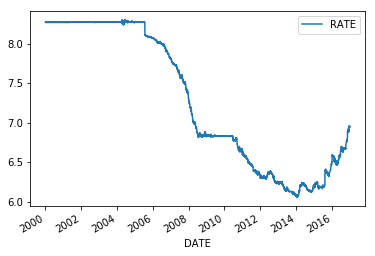

In [2]:
import quandl
mydata=quandl.get("CUR/CNY", authtoken="iY9JSt_h18shZcXLXJ-y")
mydata.plot()

## Background of CNY  

To split our dataset into a more effective subset for research, we need to summarise the reform timeline of CNY

link: https://www.scmp.com/business/money/article/2127738/timeline-yuans-journey-being-truly-global-currency

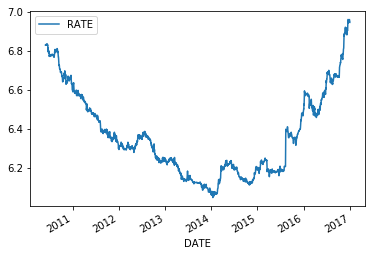

In [3]:
mydata=quandl.get("CUR/CNY", authtoken="iY9JSt_h18shZcXLXJ-y", start_date="2010-6-1")
mydata.plot()

## Stationarity

*Mean of a time series $x_t$ is $E(x_t)=\mu(t)$*

*Variance of a time series $x_t$ is $\sigma^2(t)=E[(x_t - \mu(t))^2]$*

**A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time**

**A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time**

Most of the models used in time series analysis assume covariance-stationarity. This means the predictions of these models - means, variances, and correlations, are only reliable if the data is stationary and invalid otherwise.

## Serial Correlation (Autocorrelation)

A time series model comprises of three components: trend, seasonal/cyclical, and residual or error. 

Autocorrelation is when these residuals (errors) are correlated with each other. That is, if the error of the $i_{th}$ is dependent on errors of any of the terms $0 .. i-1$ before. Essentially, it tells us how sequential observations in a time series affect each other. 

Formally, for a covariance-stationary time series, autocorrelation $\rho_k$ for lag $k$ (the number of time steps separating two sequantial observations), $$
\rho_k = \frac{COV(x_t, x_{t - k})}{\sigma_x^2} = \frac{E[(x_t - \mu)(x_{t - k} - \mu)}{\sigma_x^2}
$$

A significant value of $\rho_k$ indicates that the error of the $i_{th}$ is dependent on the previous k terms from ${i-k} .. {i-1}$.

Ignoring autocorrelation means we're likely to draw incorrect conclusions about the impact of the independent variables in our model.

## White Noise

By definition *a time series that is a white noise process has serially uncorrelated errors and the expected mean of those errors is equal to zero.* This means that the errors(residuals) are completely drawn at random from some probability distribution, i.e it is independent and identically distributed (i.i.d.). 

If our time series model results in white noise residuals, it means we have successfully captured the underlying process and explained any form of correlation, only leaving errors(residuals) which are completely random. Our predicted values differ from the observed values only by a random error component that cannot be forecasted or modeled.

Most of time series analysis is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it.

In [4]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

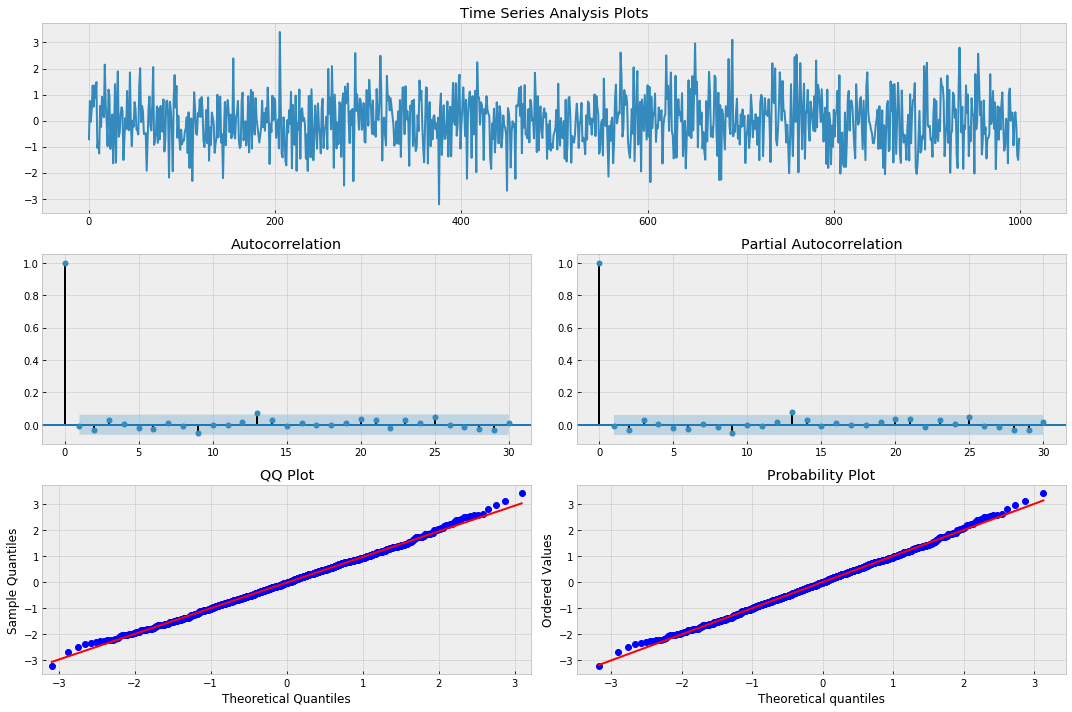

In [5]:
np.random.seed(13)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

### A word on the plots here:

* The top plot is the values of time series itself 
* The second row has plots of autocorrelation (ACF) and partial autocorrelation (PACF). The PACF is partial correlation between residuals, controlling for shorter lags. ACF can be used for investigate whether the series is staionary, and PACF can be used for dertermining the best order for AR model.
 * The x axis shows the values of the lag, $k$ and the blue shaded region show significance boundaries. Only values that lie outside the blue region are significant
* The third row has QQ plots and probability plots
 * QQ plot compares two probability distributions by plotting their quantiles against each other - If the two distributions are similar (orlinearly related), the points in the Q–Q plot will approximately lie on a line. For this discussion, we are comparing the distribution of our residuals with a normal distribution
 * Similarly, normal probability plot also asseses whether or not a data set is approximately normally distributed. The data are plotted against a theoretical normal distribution in such a way that the points should form an approximate straight line. Departures from this straight line indicate departures from normality.

We note the following:

* The process appears to be random and centered about zero
* The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation (Remember we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution)
* Below that we can see the QQ and Probability Plots, which compares the distribution of our data with standard normal distribution are straight lines

In [6]:
print("Random Series\n -------------\nmean: %.3f \nvariance: %.3f \nstandard deviation: %.3f"
      %(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: -0.022 
variance: 0.970 
standard deviation: 0.985


Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should. 

## Random Walk

A random walk is a time series model where the value of the time series variable increases or decreases (step up or down) with equal probability at each time step, that is the expected value of current observation is equal to the previous observation. It is formally defined below:

$$x_t=x_{t-1}+w_t$$ , where $w_t$ is a discrete white noise series.
$$E[x_t]=x_{t-1}$$

This means if the TS we are modeling is a random walk it is unpredictable, as they are literally random walks.

The significance of a random walk is that it is non-stationary because while the mean of a random walk is still zero, the covariance is actually time-dependent. In particular, the covariance is equal to the variance multiplied by the time. Hence, as time increases, so does the variance.

Let's simulate a random walk 

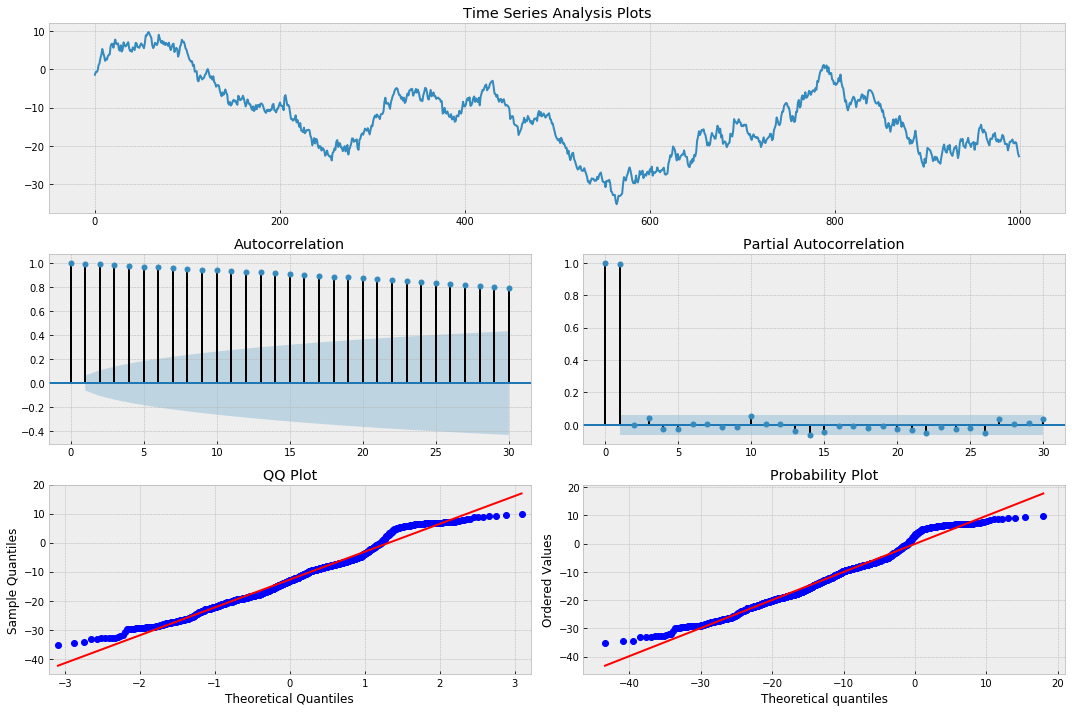

In [7]:
# Random Walk without a drift

np.random.seed(13)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. How to check if the random walk model is a good fit for our simulated data? We have

$$x_t - x_{t-1} = w_t$$ , where $w_t$ is a discrete white noise series.

The first differences of our random walk series should equal a white noise process!

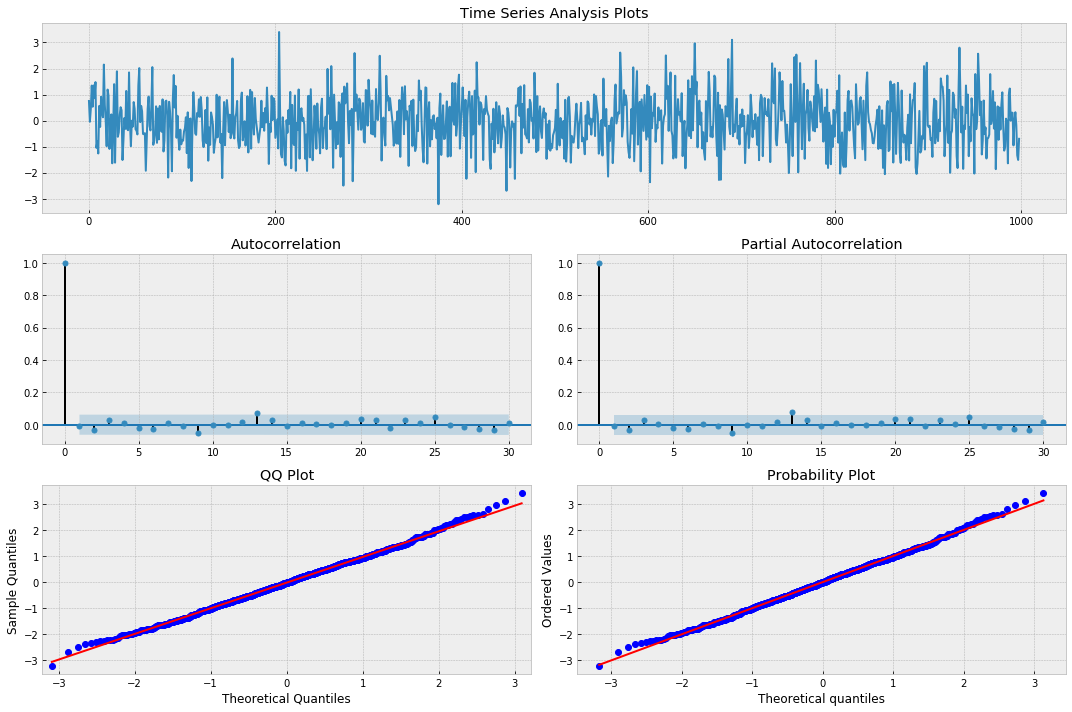

In [8]:
# First difference of simulated Random Walk series
_ = tsplot(np.diff(x), lags=30)

As expected, the difference is indeed white noise.

Let's now apply our random walk model to CNY/USD data. 

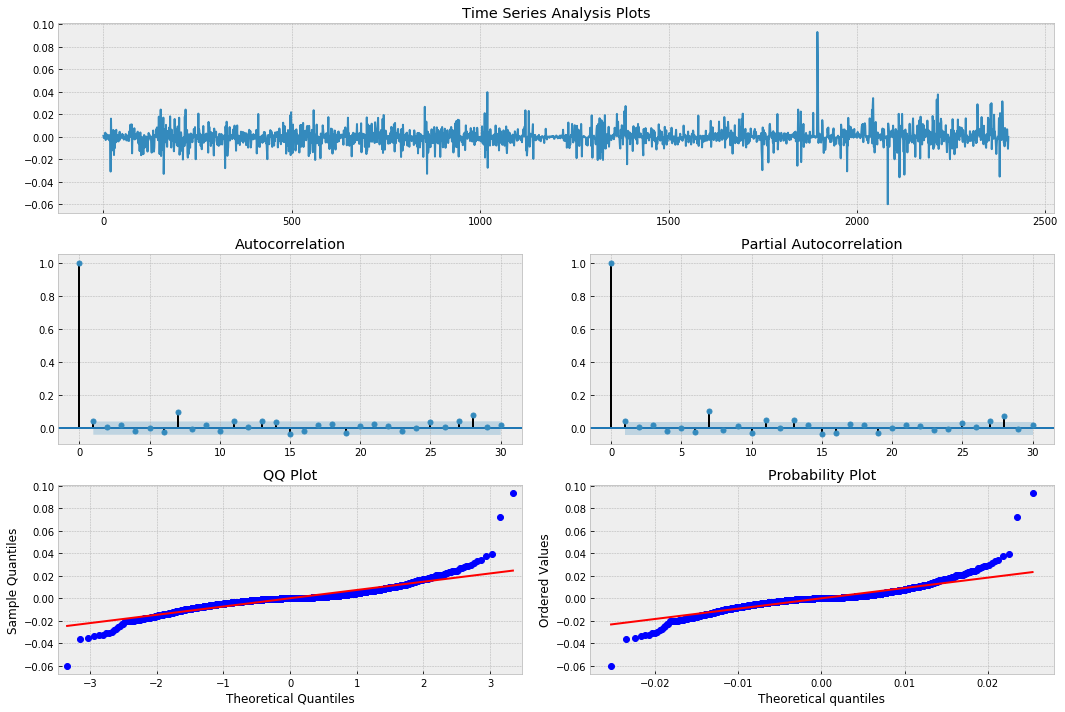

In [9]:
# First difference of CNY/USD exchange rate
_ = tsplot(np.diff(mydata.RATE), lags=30)

There appears to be some significant serial correlation in the ACF, and PACF plots around lags 7 and 28. Also notice the shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. This means that there should be better models to explain the CNY/USD exchange rate.

## Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is:
$$x_{t} = a_0+a_1 t + b$$

The value of the time series is determined by the coefficients, $a_0, a_1$ and *time*. An example could be a company's sales that increase by the same amount at each time step. For a hypthtical example, consider a company who's stock price was a 100$ to start, and increase by 50c at every time step. 

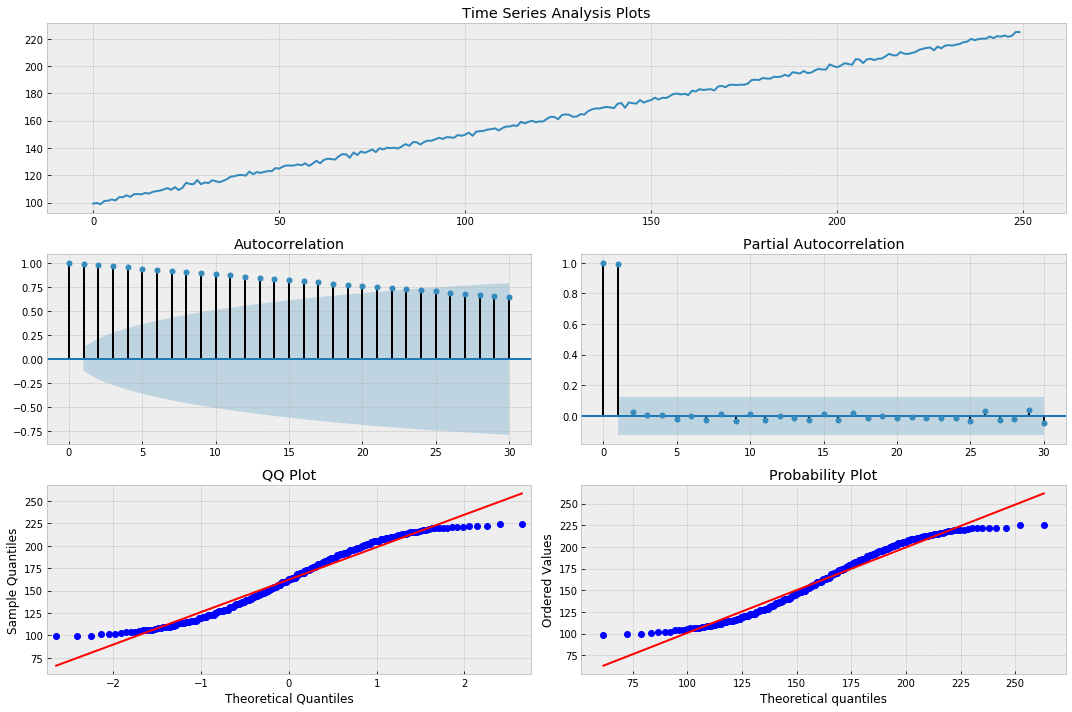

In [10]:
# simulate linear trend

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1*t + w[t]
    
_ = tsplot(x, lags=30)  

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


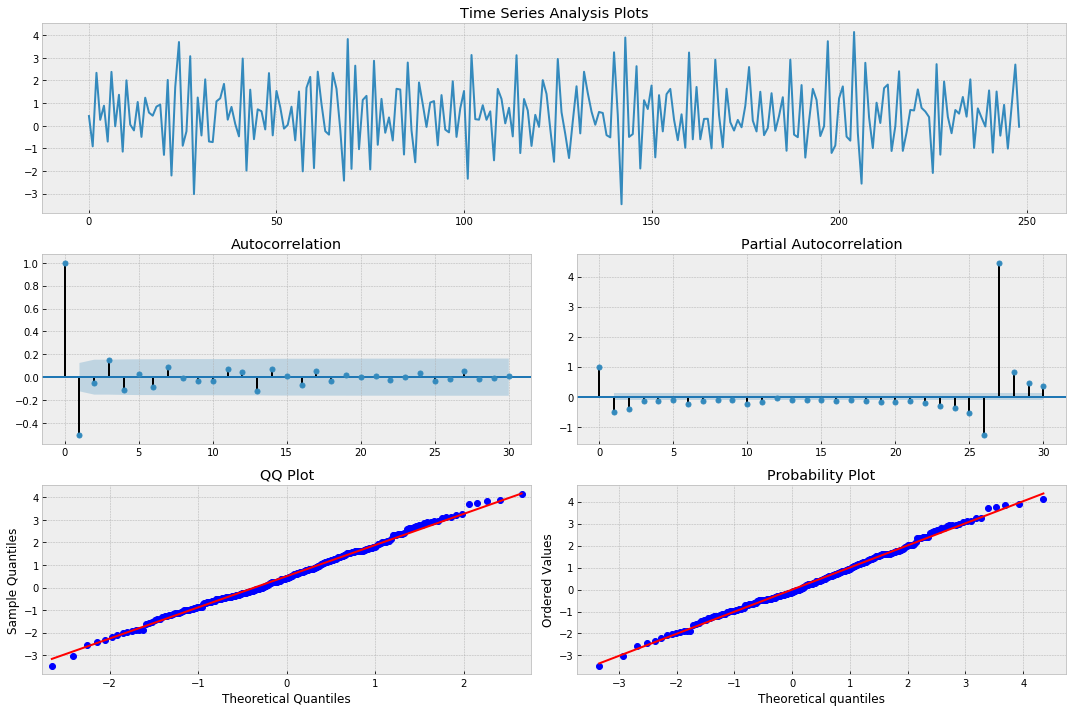

In [11]:
# First difference of simulated prices
_ = tsplot(np.diff(x), lags=30)

Here we can see that the residuals of the model are correlated. Though the distribution is approximately normal, before using this model to make predictions we would have to account for and remove the obvious autocorrelation (the significant value at lag 1) present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate.

## Log-Linear Models

Similar to linear models except that the TS that can be graphed using an exponential function. That is the the time series has a constant rate of change with respect to each time step. 
$$x_{t} = exp(a_0+a_1 t)$$
$$log(x_{t}) = a_0+a_1 t$$
$$x_0 = exp(a_0)$$
$$x_t = x_{t-1}*exp(a1)$$
For example, in our above simulated series, if the stock price increased by X% at each time step, you get a curve that looks like this:

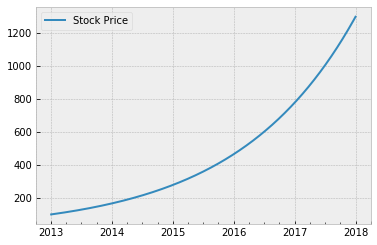

In [12]:
# Simulate exponential growth

idx = pd.date_range('2013-01-01', '2018-01-01', freq='D')
price = [np.exp( 4.605 + float(x)/712 ) for x in range(0, len(idx))]

# create dataframe and plot
df = pd.DataFrame(price, columns=['Stock Price'], index=idx)

with plt.style.context('bmh'):
    df.plot()

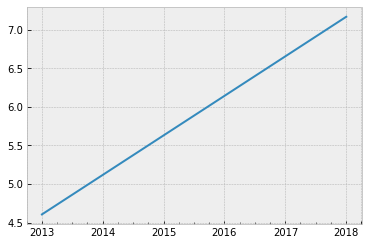

In [13]:
# log of prices

with plt.style.context('bmh'):
    pd.Series(np.log(price), index=idx).plot()

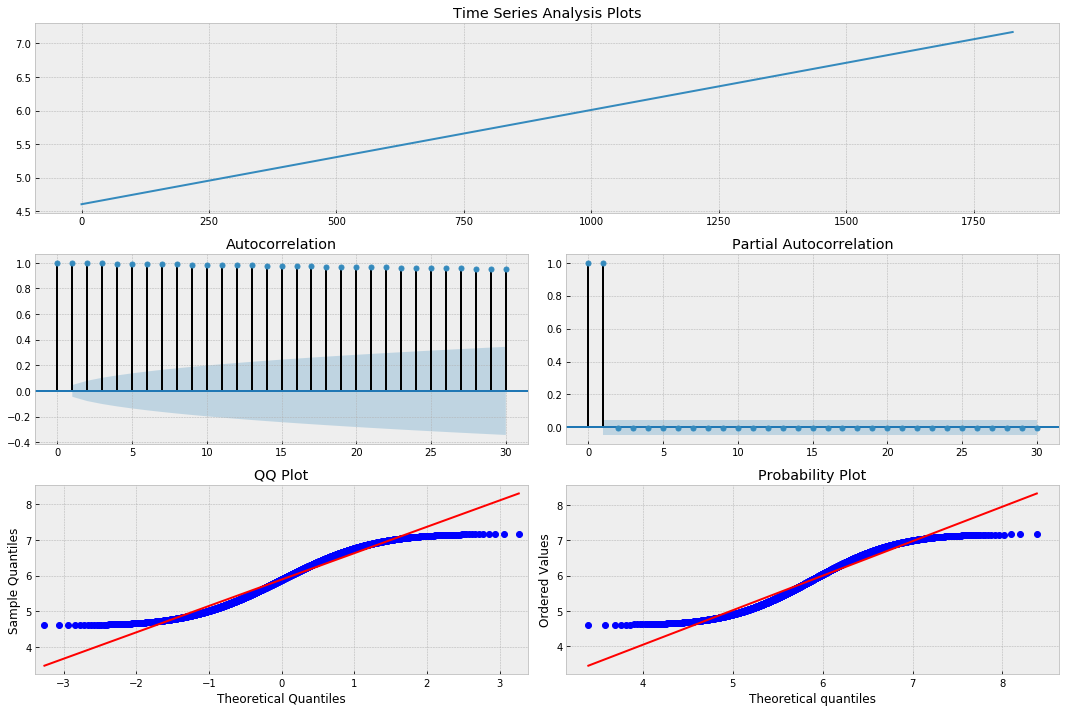

In [14]:
_ = tsplot(np.log(price), lags=30) 